# Using Diffusion Condensation to characterize PBMCs

## 0. Introduction

In this tutorial we will demonstrate how to use Diffusion Condensation to cluster different PBMC subsets across multiple granularities.  We will use a dataset generated by 10X from human blood for our tutorial.  We will introduce some functionalities of Diffusion Condensation, including calculating and visualizing diffusion homology and identifying salient clusters. We will also introduce some basics in data loading and preprocessing.

## 1. Installing and Loading packages

If you haven't already installed Diffusion Condensation, you can do so from this notebook. We will also install scprep, which is a useful package for loading and pre-processing single cell data.

In [ ]:
!pip install --user diffusion_condensation scprep

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
import scprep
import diffusion_condensation as dc
import numpy as np
import pandas as pd
import phate

## 2. Loading and filter data

In this section we will download 10X data from human PBMCs to your local computer and pre-process it for multiresolution analysis.

In [3]:
## Save data directory
data_dir = '/data/users/mkuchroo/' # enter path to data directory here (this is where you want to save 10X data)
file_name = '10X_pbmc_data.h5'

In [4]:
scprep.io.download.download_url('https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices_h5.h5', 
                                       data_dir+file_name)

In [5]:
data = scprep.io.load_10X_HDF5(data_dir+file_name,
                         gene_labels='both')

data.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
AAACCTGAGAAACCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGAAACCGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGAAACCTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGAAACGAG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGAAACGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have loaded the data, we will remove cells with low transcript counts and unexpressed genes:

In [6]:
data = scprep.filter.filter_library_size(data, cutoff=1000,  keep_cells='above')
data = scprep.filter.filter_rare_genes(data)

Finally, we will library size normalize and square root transform the expression data.

In [7]:
data_norm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

In [8]:
data_sqrt = np.sqrt(data_norm)

data_sqrt.head()

,RP11-34P13.7 (ENSG00000238009),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP4-669L17.10 (ENSG00000237094),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),NOC2L (ENSG00000188976),KLHL17 (ENSG00000187961),PLEKHN1 (ENSG00000187583),...,MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),BX004987.4 (ENSG00000278704),AC145212.2 (ENSG00000274847),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AL354822.1 (ENSG00000278384),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCTGAGAAGGCCT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,4.154662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGACAGACC-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.573422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGATAGTCA-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.449217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGCCTCA-1,0.0,0.0,0.0,0.0,2.077481,0.0,0.0,2.077481,0.0,0.0,...,0.0,5.876003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGCATGGT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,3.661874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Visualizing Data using PHATE

Before identifying populations in our dataset, it is important to visualize the geomatry of our data.

In [9]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_sqrt)

Calculating PHATE...
  Running PHATE on 4480 cells and 15434 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.70 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 6.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.46 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.67 seconds.
  Calculated landmark operator in 16.06 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.35 seconds.
Calculated PHATE in 30.08 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

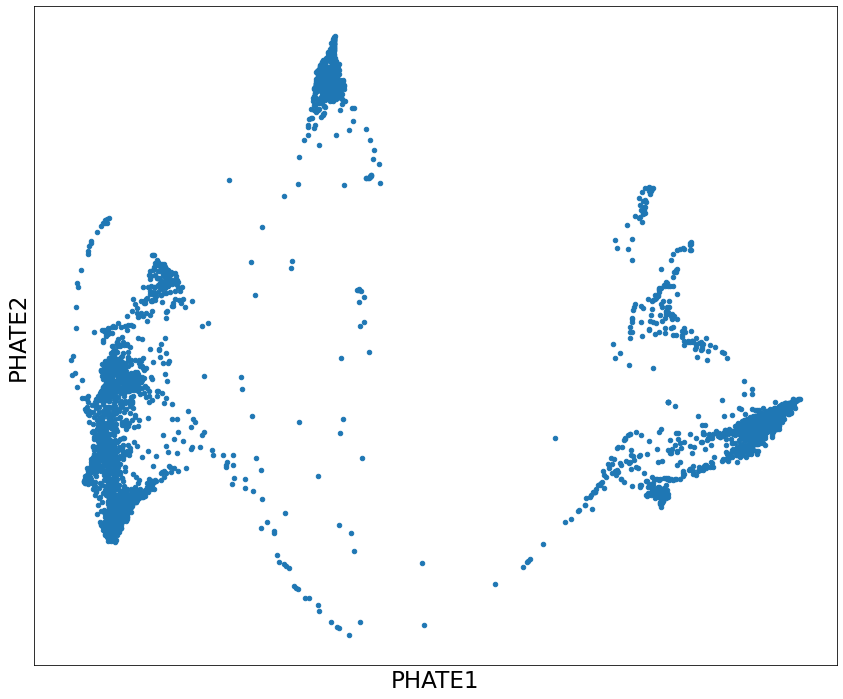

In [10]:
scprep.plot.scatter2d(data_phate, s= 20, fontsize=16, ticks=False, label_prefix="PHATE", figsize=(12,10))

## 4. Identifying multi-granular clusters with Diffusion Condensation

Computing multigranular clusters involves three successive steps:

1. Building you Diffusion Condensation operator
2. Computing manifold dimensions
3. Fitting your data with your operator to compute a diffusion homology

But first we set a random seed to make sure our results are reproducible:

In [11]:
np.random.seed(1)

dc_op = dc.Diffusion_Condensation()

dc_op.fit(data_sqrt)

Calculating Diffusion Condensation Manifold...
  Calculating PCA...
  Calculated PCA in 3.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 19.69 seconds.
  Setting epsilon to 3.0594
  Setting merge threshold to 0.1263
Calculated Diffusion Condensation Manifold in 23.25 seconds.


Next we compute our diffusion homology:

In [12]:
data_clusters = dc_op.transform()

Calculating condensation...
Calculated condensation in 4.24 seconds.


## 5. Visualizing clusters across granularities on embedding

In order to identify groupings of cells across granularities, we can visualize clusters on our PHATE embedding across granularities, start from coarse and moving finer:

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

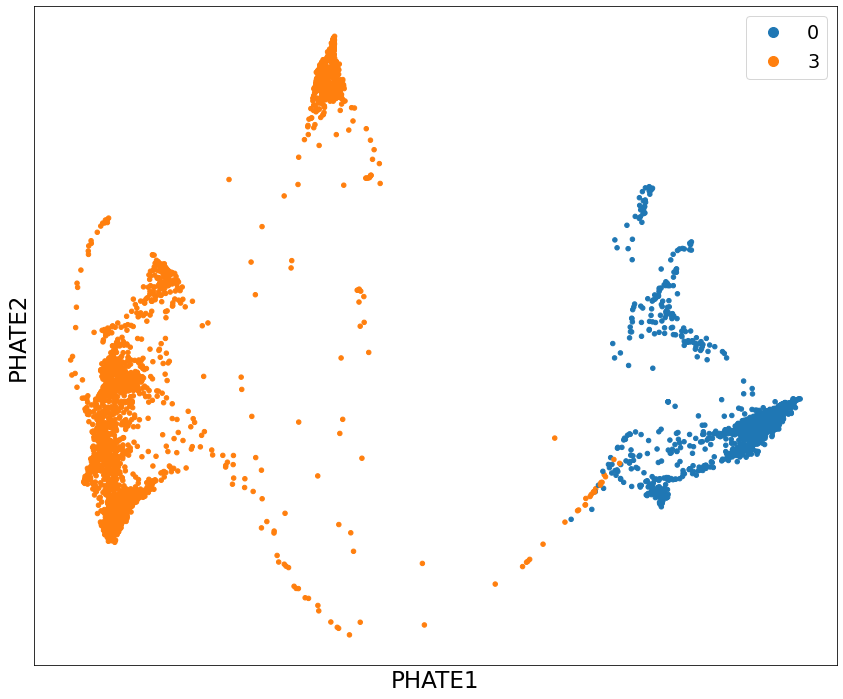

In [13]:
# Coarse granularity
scprep.plot.scatter2d(data_phate, c = data_clusters[-10], s= 20, fontsize=16, ticks=False,
                      label_prefix="PHATE", figsize=(12,10))

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

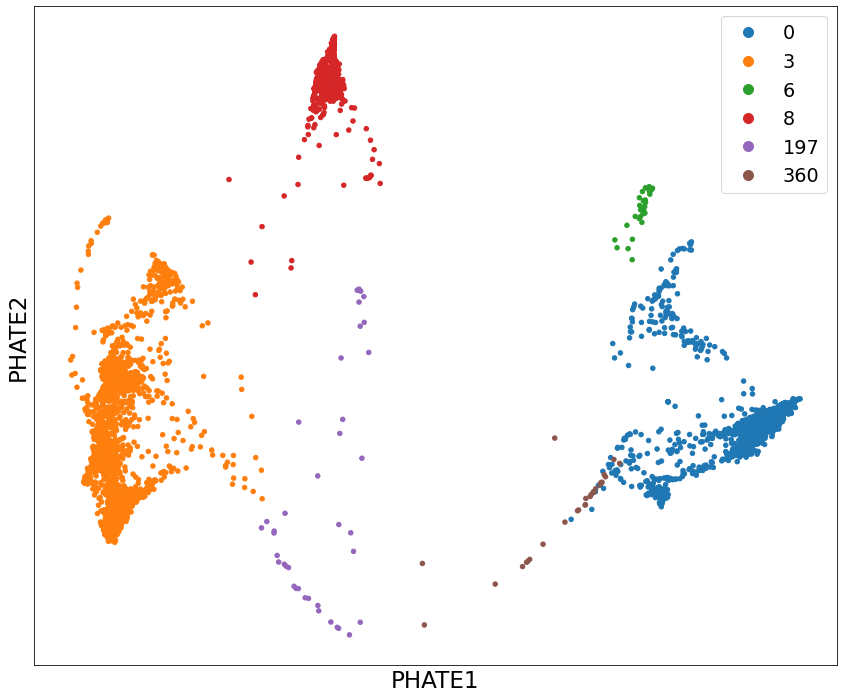

In [14]:
# Fine granularity
scprep.plot.scatter2d(data_phate, c = data_clusters[-40], s= 20, fontsize=16, ticks=False,
                      label_prefix="PHATE", figsize=(12,10))

Furthermore, we can zoom in on populations of interest to identify subpopulations:

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

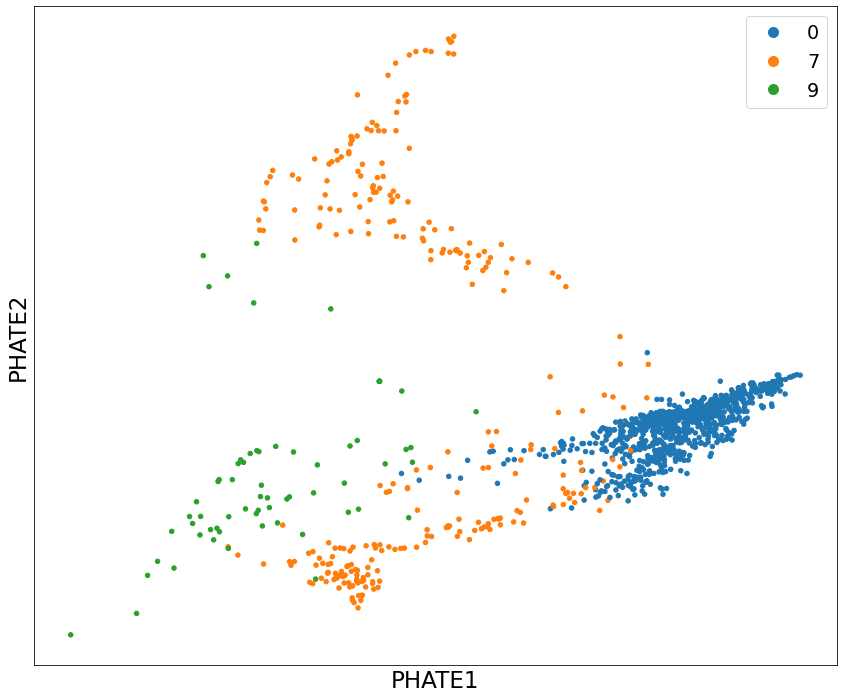

In [15]:
scprep.plot.scatter2d(data_phate[data_clusters[-40]==0], c = data_clusters[-80][data_clusters[-40]==0],
                      s= 20, fontsize=16, ticks=False,
                      label_prefix="PHATE", figsize=(12,10))

## 4. Visualizing diffusion homology

As Diffusion Condensation creates a hierarchy of cells and clusters by calculating a diffusion homology. We can visualize this homology with visualize_homology() function:

Calculating base visualization...
Calculated base visualization in 4.62 seconds.
Calculating tree...
Calculated tree in 0.08 seconds.


<Axes3DSubplot:>

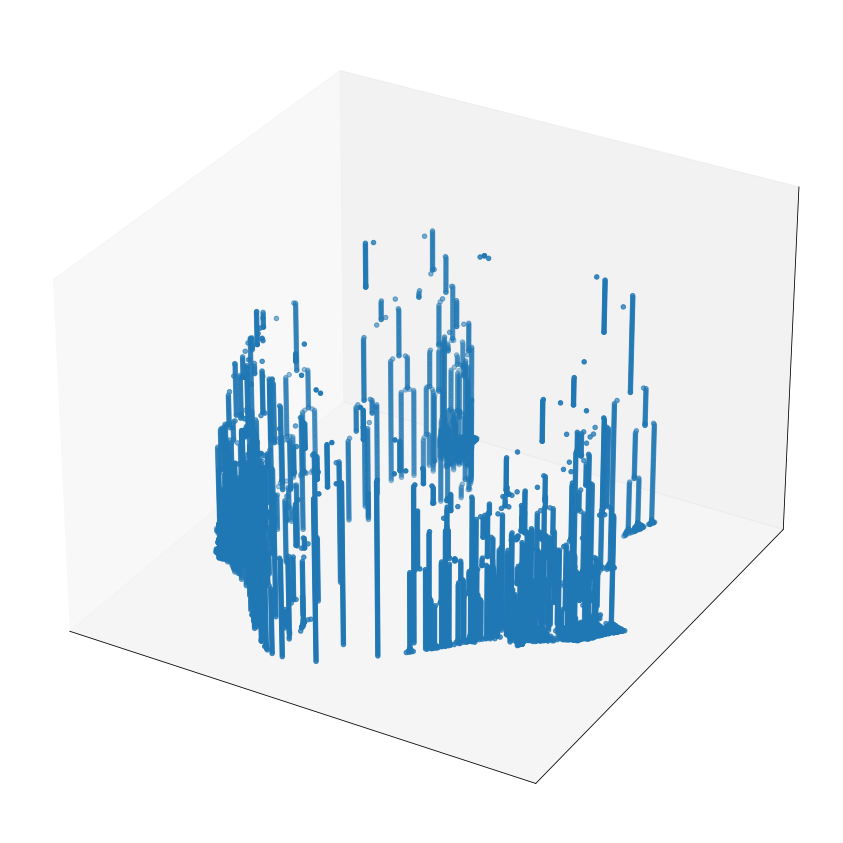

In [16]:
### building tree

tree = dc_op.visualize_homology()

scprep.plot.scatter3d(tree, s= 20,
                      fontsize=16, ticks=False, figsize=(16,12))

It can also be useful to color the homology with various labels, such as diffusion condensation iteration and by a particular layer of the homology. In order to color the tree by clusters found at a paticular granularity of the Diffusion Condensation tree, we simply pass a resolution to the .get_homology_clusters() function.

<Axes3DSubplot:>

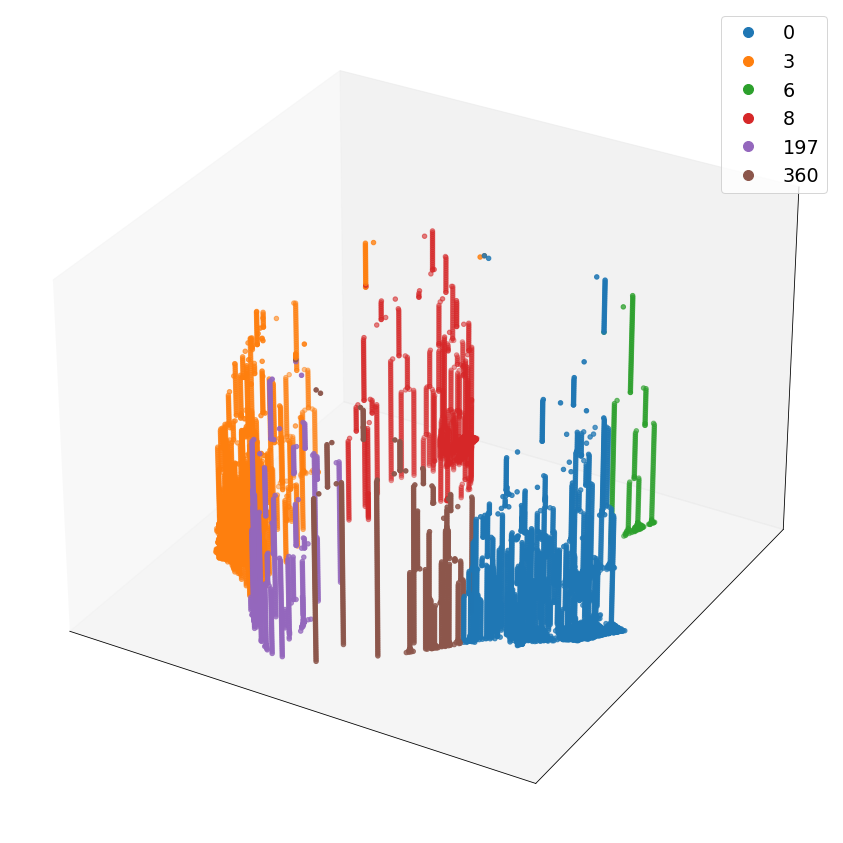

In [17]:
tree_clusters = dc_op.get_homology_clusters(-40)

scprep.plot.scatter3d(tree, c = tree_clusters, s= 20,
                      fontsize=16, ticks=False, figsize=(16,12))

## 5. Conclusion

Diffusion Condensation is a novel topologically-inspired machine learning tool that is able to analyze big datasets across multiple granularities. With our approach we are able to construct a diffusion homology which we use to group cells together across a range of granularities, helping identify celltypes and subtypes.